In [2]:
from vedo import *
import os
from ipyvtklink.viewer import ViewInteractiveWidget
import pykitti
import numpy as np
import tensorflow as tf
import time
import pickle

#limit GPU memory ------------------------------------------------
gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus)
if gpus:
  try:
    memlim = 4*1024
    tf.config.experimental.set_virtual_device_configuration(gpus[0], [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=memlim)])
  except RuntimeError as e:
    print(e)
#-----------------------------------------------------------------

from tensorflow.math import sin, cos, tan
import tensorflow_probability as tfp
import sys
current = os.getcwd()
parent_directory = os.path.dirname(current)
sys.path.append(parent_directory)
from ICET_spherical import ICET
from utils import *
from metpy.calc import lat_lon_grid_deltas
from pioneer.das.api.platform import Platform
from scipy.spatial.transform import Rotation as R
from pioneer.das.api.egomotion.imu_egomotion_provider import IMUEgomotionProvider as emp 
from matplotlib import pyplot as plt

%load_ext autoreload
%autoreload 2
%autosave 180
%matplotlib notebook

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Autosaving every 180 seconds


# Goal: Simultaneously Estimate Translation, Rotation, and Distortion

## $\mathbf{A} = [\hat{X}_{ij}, \hat{m}_{ij}] = 
\begin{bmatrix}
% x, ~ y, ~ z, ~ \phi, ~ \theta, ~ \psi, ~ x^+, ~y^+, ~z^+, ~\phi^+, ~\theta^+, ~\psi^+ \\
x, ~ y, ~ z, ~ \phi, ~ \theta, ~ \psi, ~ x^+, ~y^+, ~z^+, ~\phi^+, ~\theta^+, ~\psi^+ \\
\end{bmatrix}$

We can use newton-raphson to find A

<!-- ## $y_i = \mathbf{h}(y_j, \hat{X}_{ij}, \hat{m}_{ij}) + \mathbf{H}_m \delta m + \mathbf{H}_x \delta x + \text{H.O.T.}$ -->

## $y_i = \mathbf{h}(y_j, \hat{A}_{ij}) + \mathbf{H}_A \delta A + \text{H.O.T.}$

## $\mathbf{H}_A \in \mathbb{R}^{4N \times 12} $



### $\mathbf{H}_A = [H_X, H_m]$

# Problem:  what if distortion correction and rigid transform both work equally well?

(ex: there are not enough features on one side to completely enclose the vehicle)

### IT MAKES LIFE WAY EASIER IF I SUPPRESS ANGULAR COMPONENT OF MOTION PROFILE??

### Run Demo

In [3]:
# load point cloud
# # no distortion
# old_cloud =  np.load("sample_data/paper_figures/case1/raw_frame_0.npy")
# # m_hat = np.array([0., 0., 0., 0., 0., 0.0]) #actual motion
# m_hat = np.array([-3., 0., 0., 0., 0., 0.1]) #test wrap around

# movement in x
old_cloud =  np.load("sample_data/paper_figures/case2/raw_frame_3.npy") 
# m_hat = np.array([3, 0, 0., 0., 0., 0])
m_hat = np.array([3., 0, 0., 0., 0., -0.2]) #FOR DEBUG-- deform just a little
gt =  np.load("sample_data/paper_figures/case2/base_vel_2.npy")

# # movement in x, y, & yaw
# old_cloud =  np.load("sample_data/paper_figures/case3/raw_frame_1.npy") 
# m_hat = np.array([3, -1, 0., 0., 0., -1])
# # m_hat = np.array([3, -1, 0., 0., 0., -0.86]) #FOR DEBUG-- deform a little extra
# # m_hat = np.array([3., -1., 0., 0., 0., -0.1]) #FOR DEBUG
# gt =  np.load("sample_data/paper_figures/case3/base_vel_2.npy")
# # print(gt) 

# period_lidar = 1
# t_scale = (2*np.pi)/(-m_hat[-1] + (2*np.pi/period_lidar))
# print(t_scale)
# m_hat = m_hat*t_scale
# # m_hat[-1] = m_hat[-1]*t_scaled
# print(m_hat)

#downsample
old_cloud = old_cloud[::5,:]

In [4]:
#apply ground truth distortion according to m_hat
try:
    new_cloud = dc.apply_motion_profile(old_cloud, m_hat, period_lidar=1)
except:
    from remove_motion_basic import linear_correction_old as lc #old method (straight from ROS node) 
    print("using backup")
    new_cloud = lc(old_cloud, m_hat) 

#set ground truth transform between clouds
# X_gt = np.array([0, 0., 0.0, 0.0, 0.0, 0.0])
# X_gt = np.array([1.5, 0.5, 0.03, 0.03, 0.03, 0.25])
# X_gt = np.array([1.5, -3, 0.1, 0.2, 0.03, -0.15])
X_gt = np.array([-1., 0., 0.0, 0., 0., 0.])

# add noise
old_cloud += 0.01*np.random.randn(np.shape(old_cloud)[0], 3)

# #for fig: mess up both again to show that relative distortion remains constant
# new_cloud = lc(new_cloud, -m_hat)
# old_cloud = lc(old_cloud, -m_hat)
# old_cloud = lc(old_cloud, 0.2*m_hat)

# #remove ground plane
# old_cloud = old_cloud[old_cloud[:,2] > -1] 
# new_cloud = new_cloud[new_cloud[:,2] > -1] 

#remove left half of each point cloud
# old_cloud = old_cloud[:(len(old_cloud)//2),:]
# new_cloud = new_cloud[:(len(new_cloud)//2),:]
# # 2/3 of each point cloud
# old_cloud = old_cloud[:(len(old_cloud)//3),:]
# new_cloud = new_cloud[:(len(new_cloud)//3),:]

# #get rid of two walls but leave ground plane
# a = np.where(old_cloud[:,2] < -1.4) 
# b = np.where(old_cloud[:,1] > 0)
# c = np.where(old_cloud[:,0] > -8)
# idx = np.union1d(np.intersect1d(b,c),a)
# old_cloud = old_cloud[idx]
# new_cloud = new_cloud[idx]

# Rotate + Translate new point cloud
trans = X_gt[:3]
rot = R_tf(X_gt[3:]).numpy()
new_cloud = (new_cloud @ rot) + trans

plt = Plotter(N = 1, axes = 4, bg = (1, 1, 1), interactive = True)
disp=[]
disp.append(Points(old_cloud, c = "#CB2314")) 
# disp.append(Points(old_cloud[:4000], c = "#CB2314")) 
disp.append(Points(new_cloud, c = "#2c7c94")) 
plt.show(disp, "raw point clouds")
ViewInteractiveWidget(plt.window)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
using backup


/home/derm/anaconda3/envs/py39/lib/python3.9/site-packages/vtkmodules/util/numpy_support.py:74: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  _vtk_np = {vtkConstants.VTK_BIT:numpy.bool,


ViewInteractiveWidget(height=1043, layout=Layout(height='auto', width='100%'), width=1280)

### Attempt to solve with basic 6 state solution (Impossible)

In [ ]:
from linear_corrector import LC
pc1 = old_cloud
pc2  = new_cloud
m_hat0 = np.array([0, 0, 0, 0, 0, 0.])
dc = LC(cloud1 = pc2, cloud2 = pc1, fid = 50, niter = 20, draw = True, 
        m_hat0 = m_hat0,  mnp = 25, RM = False, solver='6_state')
ViewInteractiveWidget(dc.plt.window)


### Run Newton-Raphson with a priori correspondences

In [ ]:
A_hat = np.array([0., 0, 0, 0, 0, 0, 
                  0, 0, 0, 0, 0, 0])
skip = 1 #50
y_i = new_cloud[::skip] #baseline
y_j = old_cloud[::skip] #distorted cloud

print("num corr total:", len(y_i))

plt = Plotter(N = 1, axes = 4, bg = (1, 1, 1), interactive = True)
disp=[]
disp.append(Points(y_i[:,:3], c = "#a65852 ", alpha = 0.5, r=5.5)) #

runlen = 20
for count in range(runlen):
    
    print("~~~~ iteration ", count, "~~~~~~~~~~~")
#     print("A_hat = \n", np.round(A_hat[:6],4), "\n", np.round(A_hat[6:],4)) 
    print("A_hat = \n", A_hat[:6], "\n", A_hat[6:]) 

    #decompose A_hat into X_hat and m_hat
    X_hat = A_hat[:6] 
    m_hat = A_hat[6:]
    
    #apply last estimate of distortion correction
    y_j_undistort = lc(y_j, m_hat)
    #apply last rigid transform
    rot = R_tf(X_hat[3:]).numpy()
    trans = X_hat[:3]
    y_j_undistort = (y_j_undistort @ rot) + trans

#     print("rot: \n", rot,"\n trans: \n", trans)  
#     print("\n y_i \n",np.shape(y_i), "\n", y_i[:3])
#     print("y_j_undistort \n",np.shape(y_j_undistort), "\n", y_j_undistort[:3])
    
    #get jacobain of distortion correction function, [H_X, H_m]
    H_m = dc.get_H_m(y_j_undistort, m_hat) 
#     print("\n H_m:", np.shape(H_m), "\n", H_m[:10])
    
    #get jacobian of rigid transform function 
    H_x = jacobian_tf(tf.transpose(tf.convert_to_tensor(y_j_undistort, tf.float32)), tf.convert_to_tensor(X_hat[3:], tf.float32)) # shape = [num of corr * 3, 6]
    #need to append on a row of zeros since we are working with homogeneous coordinates!
    H_x = tf.reshape(H_x, (tf.shape(H_x)[0]//3, 3, 6)) # -> need shape [#corr//4, 4, 6]
#     print("\n H_x before:", np.shape(H_x), "\n", H_x[0])
    H_x = tf.concat([H_x, tf.zeros([len(H_x),1,6])], axis = 1)
    H_x = tf.reshape(H_x, (-1, 6))
#     print("\n H_x after:", np.shape(H_x), "\n", H_x[:10])
    H_x = H_x.numpy()
        
    #delta_A =  ((H^T*H)^-1)(H^T)(yi - yj_undistort)
    residual = (np.append(y_i, np.ones([len(y_i),1]), axis = 1) -
                np.append(y_j_undistort, np.ones([len(y_i),1]), axis = 1)).flatten()
#     print("residual", np.shape(residual), "\n", residual)
    
    H = np.append(H_x, H_m, axis = 1)
    print("H: \n", np.shape(H))

    print("pinv(HTH): \n", np.shape(np.linalg.pinv(H.T @ H)))
    print("pinv(HTH) @ H.T: \n", np.shape(np.linalg.pinv(H.T @ H) @ H.T))
    
    delta_A = np.linalg.pinv(H.T @ H) @ H.T @ residual
    print("\n delta_A \n", np.round(delta_A[:6], 5), "\n", np.round(delta_A[6:], 5))
    #augment rigid transform components
    A_hat[:6] -=   delta_A[:6]
    #augment distortion components
    A_hat[6:9] -= delta_A[6:9]
    A_hat[9:] += delta_A[9:]

    #plot updated cloud2
#     color = [0.5 + count/(runlen*2), 1 - (count+1)/runlen, (count+1)/runlen]
#     disp.append(Points(y_j_undistort[:,:3], c = color, r=3.5))
    disp.append(Points(y_j_undistort[:,:3], c = "#2c7c94 ", alpha = (count+1)/(runlen+1), r=3.5))

    
plt.show(disp, "12 State Solution")
ViewInteractiveWidget(plt.window)

# Run toy problem again with voxel-based correspondences

In [ ]:
from linear_corrector import LC

A0 = np.array([0., 0, 0, 0, 0, 0,
               0, 0, 0, 0, 0, 0])
print("actual X, m: \n", X_gt, "\n", m_hat )

dc = LC(cloud1 = new_cloud, cloud2 = old_cloud, fid = 40, niter = 25, 
        draw = True, mnp = 25, RM = False, solver = '12_state', 
        max_buffer = 2.5, A0 = A0)
ViewInteractiveWidget(dc.plt.window)

# Run 12-State on Ford Campus Dataset

In [8]:
#test registration on single scan pair

i = 2500 #990

ground_truth = np.loadtxt("../spherical_paper/FORD_results/truth_body_frame.txt") # [0, v_xandy, v_vertical, r, p, y]
gt = (ground_truth[i,:] + ground_truth[i+1,:])/20 #avg between pts
print("gt: \n", gt[0], gt[1])

fn1 = '/media/derm/06EF-127D3/Ford/IJRR-Dataset-1/SCANS/Scan%04d.mat' %(i+75)
fn2 = '/media/derm/06EF-127D3/Ford/IJRR-Dataset-1/SCANS/Scan%04d.mat' %(i+76)
dat1 = mat4py.loadmat(fn1)
SCAN1 = dat1['SCAN']
pc1 = np.transpose(np.array(SCAN1['XYZ']))
dat2 = mat4py.loadmat(fn2)
SCAN2 = dat2['SCAN']
pc2 = np.transpose(np.array(SCAN2['XYZ']))

#flip order in which points appear in each cloud (so scanner spins ccw in stead of cw)
pc1 = np.flip(pc1, axis = 0)
pc2 = np.flip(pc2, axis = 0)
#test: try just flipping sign on y values....
# pc1[:,1] = -pc1[:,1]
# pc2[:,1] = -pc2[:,1]

#need to rotate point clouds so the scan starts aligned with +x axis
rot = R_tf(np.array([0,0,-np.pi/2])).numpy()
pc1 = pc1 @ rot
pc2 = pc2 @ rot

A0 = np.array([gt[1], 0, 0, 0, 0, 0,
               0, 0, 0, 0, 0, 0])
# A0 = np.array([0., 0, 0, 0, 0, 0,
#                0, 0, 0, 0, 0, 0])

#run 12 State Rigid Transform + Distortion Correction
dc = LC(cloud1 = pc1, cloud2 = pc2, fid = 50, niter = 15, A0 = A0,
    draw = True, mnp = 50, RM = False, solver = '12_state', 
        max_buffer = 0.5)
ViewInteractiveWidget(dc.plt.window)

# #just run ICET (for debug)
# it = ICET(cloud1 = pc1, cloud2 = pc2, fid = 50, niter = 10, 
#            draw = True, group = 2, RM = True, DNN_filter = False)
# ViewInteractiveWidget(it.plt.window)

gt: 
 0.0 0.8340382716116025
A0:
 [0.83403827 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.        ]
~~~~~~~~~~~Iteration  0 ~~~~~~~~~~


2023-05-09 10:05:09.570497: I tensorflow/stream_executor/cuda/cuda_blas.cc:1614] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-05-09 10:05:09.695046: I tensorflow/core/util/cuda_solvers.cc:179] Creating GpuSolver handles for stream 0x856bba0



 new: 
 [0. 0. 0. ... 0. 0. 0.]
num corr: 
 tf.Tensor([201], shape=(1,), dtype=int32)
LUT tf.Tensor([201   3   3], shape=(3,), dtype=int32)

 residuals (603, 1)

 delta_A
 (12,)
A: 
 [ 8.021e-01  1.000e-04 -1.000e-03 -6.000e-04  3.200e-03  1.100e-03] 
 [-0.0208  0.0035 -0.0068  0.0027 -0.0035 -0.0016]
~~~~~~~~~~~Iteration  1 ~~~~~~~~~~

 new: 
 [-0.00025906 -0.00019832  0.00033662 ...  0.02028207  0.02015414
  0.02005045]
num corr: 
 tf.Tensor([201], shape=(1,), dtype=int32)
LUT tf.Tensor([201   3   3], shape=(3,), dtype=int32)

 residuals (603, 1)

 delta_A
 (12,)
A: 
 [ 8.01e-01  1.31e-02 -4.80e-03 -2.00e-04  3.40e-03  9.10e-03] 
 [-0.0216  0.0093 -0.0076  0.0019 -0.0039 -0.0143]
~~~~~~~~~~~Iteration  2 ~~~~~~~~~~

 new: 
 [-0.00024149 -0.00017859  0.00037612 ...  0.02104654  0.020914
  0.0208066 ]
num corr: 
 tf.Tensor([200], shape=(1,), dtype=int32)
LUT tf.Tensor([200   3   3], shape=(3,), dtype=int32)

 residuals (600, 1)

 delta_A
 (12,)
A: 
 [ 8.044e-01  2.290e-02 -4.400e-03 -2

ViewInteractiveWidget(height=1043, layout=Layout(height='auto', width='100%'), width=1280)

<IPython.core.display.Javascript object>


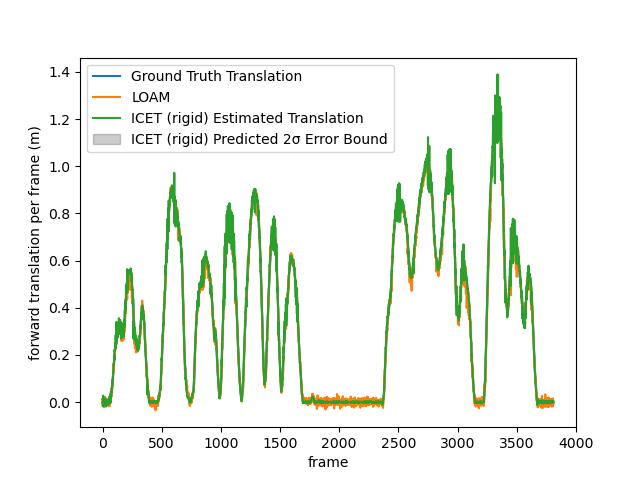

In [57]:
#load ground truth data and rigid transform ICET results
# estimates = np.loadtxt("../results/Ford_full_estimates_v10.txt") #was this
# pred_stds = np.loadtxt("../results/Ford_full_pred_stds_v10.txt")
estimates = np.loadtxt("../Ford_full_estimates_v12.txt") #test 5/8/23
pred_stds = np.loadtxt("../Ford_full_pred_stds_v12.txt")

ground_truth = np.loadtxt("../spherical_paper/FORD_results/truth_body_frame.txt") # [0, v_xandy, v_vertical, r, p, y]
LOAM = np.loadtxt("../spherical_paper/FORD_results/LOAM.txt")
# LOAM = np.loadtxt("../spherical_paper/FORD_results/LOAM_v2.txt")
ICP = np.loadtxt("../spherical_paper/FORD_results/ICP.txt")
# NDT = np.loadtxt("../spherical_paper/FORD_results/NDT_cart_v2.txt") #very bad
runlen = np.shape(estimates)[0]
estimates = estimates[1:,:]
pred_stds = pred_stds[1:,:]
vf = (ground_truth[:runlen-1,1]/10 + ground_truth[1:runlen,1]/10)/2 #v5

#plot ground truth vs raw ICET estimates
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.plot(vf, label = 'Ground Truth Translation')
# print(estimates[:,0])
ax.plot(LOAM[:,1], label = "LOAM")
ax.plot(estimates[:,1], label = "ICET (rigid) Estimated Translation") #was this
#NOTE-- adjust linspace here when shifting
ax.fill_between(np.linspace(0,runlen-2,runlen-1),
                   vf - 2*pred_stds[:,1], vf + 2*pred_stds[:,1], 
                   color = [0,0,0], alpha = 0.2, label = 'ICET (rigid) Predicted 2σ Error Bound')
ax.set_xlabel("frame")
ax.set_ylabel("forward translation per frame (m)")
ax.legend(loc = 'best')

## Full Ford Datset

In [7]:
from linear_corrector import LC
import mat4py

start_idx = 0 #990 #start on this scan
runlen = 3680 #250
m_hat_history = np.zeros([runlen, 6])
X_hat_history = np.zeros([runlen, 6])
X_hat_history_ICET = np.zeros([runlen, 6])
seed_hist = np.zeros([runlen, 6])

A0 = np.array([0., 0, 0, 0, 0, 0,
               0., 0, 0, 0, 0, 0])

for i in range(runlen):
    print("---------------------------------- SCAN IDX", i + start_idx,"-------------------------------------")

    #load point clouds
    fn1 = '/media/derm/06EF-127D3/Ford/IJRR-Dataset-1/SCANS/Scan%04d.mat' %(i+start_idx+75)
    fn2 = '/media/derm/06EF-127D3/Ford/IJRR-Dataset-1/SCANS/Scan%04d.mat' %(i+start_idx+76)
    dat1 = mat4py.loadmat(fn1)
    SCAN1 = dat1['SCAN']
    pc1 = np.transpose(np.array(SCAN1['XYZ']))
    dat2 = mat4py.loadmat(fn2)
    SCAN2 = dat2['SCAN']
    pc2 = np.transpose(np.array(SCAN2['XYZ']))

    #align point clouds using ground truth
    ground_truth = np.loadtxt("/media/derm/06EF-127D3/Ford/IJRR-Dataset-1/SCANS/FORD_DS1_truth.txt")/10
    ground_truth = tf.cast(tf.convert_to_tensor(ground_truth), tf.float32)
    gt = (ground_truth[i+start_idx,:] + ground_truth[i+start_idx+1,:])/2 #avg between pts
        
    #flip order in which points appear in each cloud (so scanner spins ccw in stead of cw)
    pc1 = np.flip(pc1, axis = 0)
    pc2 = np.flip(pc2, axis = 0)
    #need to rotate point clouds so the scan starts aligned with +x axis
    rot = R_tf(np.array([0,0,-np.pi/2])).numpy()
    pc1 = pc1 @ rot
    pc2 = pc2 @ rot

#     #apply "ground truth" transform to point clouds
#     trans = np.array([gt[1], gt[0], gt[2]])
#     trans[0] += 0.01 #add noise to x
#     rot = R_tf(-gt[3:]).numpy().T
#     pc2_transformed =  (pc2 @ rot) + trans 
    
#     print("\n trans, rot GT: \n", trans, -gt[3:].numpy())

    
#     #apply output of ICET to raw point clouds ~~~~~~~~~~~~~~~~~~~
#     #align point clouds using ICET output, seed ICET input with ground truth to ensure convergence
#     it = ICET(cloud1 = pc1, cloud2 = pc2, fid = 50, niter = 10, 
#            draw = False, group = 2, RM = True, DNN_filter = False, x0 = gt)
#     #ViewInteractiveWidget(it.plt.window)
#     gt = it.X
#     trans = it.X[:3].numpy()
#     rot = R_tf(-it.X[3:]).numpy().T
#     pc2_transformed =  (pc2 @ rot) + trans 
#     print("\n trans, rot it.X \n", trans, -it.X[3:].numpy())
#     #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    
#     #run 12 State Rigid Transform + Distortion Correction
#     dc = LC(cloud1 = pc1, cloud2 = pc2, fid = 50, niter = 25, 
#         draw = False, mnp = 25, RM = True, solver = '12_state', max_buffer = 1.0)
    
    noise = 0.05*np.random.randn()
#     run 6 State Rigid Transform ONLY
    x0 = tf.constant([gt[1].numpy()+noise, 0, 0, 0, 0, 0], tf.float32)
    it = ICET(cloud1 = pc1, cloud2 = pc2, fid = 70, niter = 10, x0 = x0,
           draw = False, group = 2, RM = True, DNN_filter = False)
    seed_hist[i,0] = gt[1].numpy()+noise
    
#     #seed initial alignments close to GT solution
#     A0 = np.array([gt[1]+noise, 0, 0, 0, 0, 0,
#                    0,           0, 0, 0, 0, 0])
    #seed initial alignments close to ICET solution
    A0 = np.array([it.X[0], it.X[1], it.X[2], it.X[3], it.X[4], it.X[5],
                   0., 0., 0., 0., 0., 0.])
#     A0[:6] = np.array([it.X[0], it.X[1], it.X[2], it.X[3], it.X[4], it.X[5]])
#     run 12 State Rigid Transform + Distortion Correction
    dc = LC(cloud1 = pc1, cloud2 = pc2, fid = 50, niter = 5, A0 = A0,
        draw = False, mnp = 50, RM = False, solver = '12_state', max_buffer = 0.3)
#     if A0[6] < 0.05:
#         A0[6:] = dc.A[6:] #test feeding last distortion bounds as input for next iter
#     else:
#         A0[6:] = np.array([0., 0., 0., 0., 0., 0.]) #zero out if they get too big
        
#     #zero out initial estimates (assume rigid ICET got us most of the way there)
#     A0 = np.array([0., 0, 0, 0, 0, 0,
#                    0, 0, 0, 0, 0, 0])
#     #run 12 State on STATIC portions of clouds ONLY
#     dc = LC(cloud1 = it.cloud1_static, cloud2 = it.cloud2_static, fid = 50, niter = 10, A0 = A0,
#         draw = False, mnp = 50, RM = False, solver = '12_state', max_buffer = 0.3)
    
    X_hat_history[i,:] = dc.A[:6] #when feeding output of rigid ICET as x0
#     X_hat_history[i,:] = dc.A[:6] + it.X #when using "static PC" output
    m_hat_history[i,:] = dc.A[6:]
    X_hat_history_ICET[i,:] = it.X

---------------------------------- SCAN IDX 0 -------------------------------------


2023-05-09 10:05:04.662050: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


KeyboardInterrupt: 

### plot bounds for forward movement

<IPython.core.display.Javascript object>


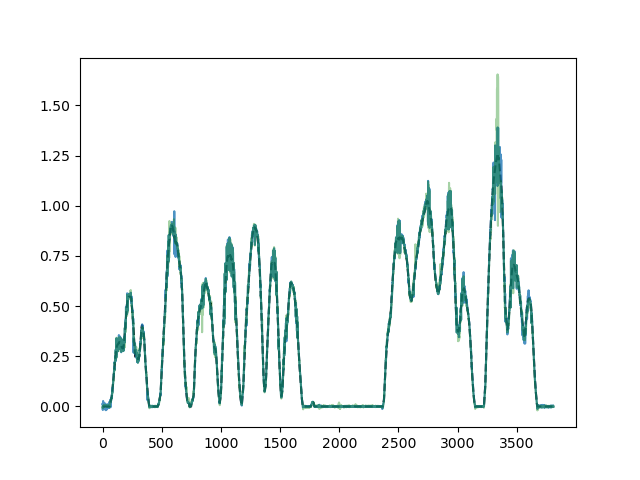

2023-05-10 00:26:02.718766: W tensorflow/core/framework/op_kernel.cc:1768] INVALID_ARGUMENT: required broadcastable shapes


InvalidArgumentError: {{function_node __wrapped__Sub_device_/job:localhost/replica:0/task:0/device:GPU:0}} required broadcastable shapes [Op:Sub]

In [61]:
pred_stds = np.loadtxt("../results/Ford_full_pred_stds_v10.txt")
pred_stds = pred_stds[(start_idx):(start_idx+runlen),:]

import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ground_truth = np.loadtxt("/media/derm/06EF-127D3/Ford/IJRR-Dataset-1/SCANS/FORD_DS1_truth.txt")/10
ground_truth = tf.cast(tf.convert_to_tensor(ground_truth), tf.float32)
# gt = (ground_truth[i+start_idx,:] + ground_truth[i+start_idx+1,:])/2 #avg between pts
vf = (ground_truth[(start_idx+1):(start_idx+runlen+1),1] + ground_truth[start_idx:(start_idx+runlen),1])/2 #works best(?)
# vf = ground_truth[(start_idx+1):(start_idx+runlen+1),1] #test

ax.plot(vf, 'k--', label = 'Ground Truth Translation')
# ax.plot(estimates[start_idx:(start_idx+runlen),1], label = "ICET Estimated Translation (rigid)") #old rigid

# ax.plot(X_hat_history[1:,0], alpha = 0.8, label = "ICET Registration (12 State)")
# ax.plot(X_hat_history_ICET[:,0], alpha = 0.8, label = "ICET Registration (6 State)") #same params as 12 state
ax.plot(estimates[start_idx:(start_idx+runlen),1], alpha = 0.8, label = "ICET")#"ICET Registration (tuned 6 State)") #old full run optimized ICET
# ax.plot(seed_hist[:,0], 'k.', alpha = 0.3, label = "ICET initial seed" )
# ax.plot(LOAM[1:,1], alpha = 0.5, label = "LOAM")
ax.plot(ICP[1:,1], 'g', alpha = 0.35, label = "ICP")
# ax.plot(NDT[1:,1], 'g--', alpha = 0.8, label = "NDT")

# ax.fill_between(np.linspace(0,runlen-1,runlen),
#                    vf - 2*pred_stds[:,1], vf + 2*pred_stds[:,1], 
#                    color = [0,0,0], alpha = 0.2, label = 'ICET Predicted 2σ Error Bound')

# ax.fill_between(np.linspace(0,runlen-1,runlen),
#                    vf - m_hat_history[:,0], vf + m_hat_history[:,0], 
#                    color = [1,0,0], alpha = 0.3, label = 'Distortion Bounds (12 State)')

# plot distortion bounds w.r.t. gt
# ax.fill_between(np.linspace(0,runlen-2,runlen-1),
#                    vf[:-1] - abs(m_hat_history[1:,0])-2*abs(pred_stds[1:,1]), 
#                    vf[:-1] + abs(m_hat_history[1:,0]) + 2*abs(pred_stds[1:,1]), 
#                    color = [1,0,0], alpha = 0.3, label = 'Distortion Bounds')
ax.fill_between(np.linspace(0,runlen-3,runlen-2),
                   vf[:-2] - abs(m_hat_history[2:,0])-2*abs(pred_stds[2:,1]), 
                   vf[:-2] + abs(m_hat_history[2:,0]) + 2*abs(pred_stds[2:,1]), 
                   color = [1,0,0], alpha = 0.5, label = '2σ + Distortion Bounds')

# # plot distortion bounds w.r.t. 12-State ICET Estimaes
# ax.fill_between(np.linspace(0,runlen-1,runlen),
#                    X_hat_history[:,0] - abs(m_hat_history[:,0])-2*abs(pred_stds[:,1]), 
#                    X_hat_history[:,0] + abs(m_hat_history[:,0]) + 2*abs(pred_stds[:,1]), 
#                    color = [1,0,0], alpha = 0.3, label = '2σ + 2*Distortion Bounds (12 State)')

ax.set_title("Ford Campus Dataset: 12-state ICET")
ax.set_xlabel("frame index")
ax.set_ylabel("forward translation per frame (m)")
ax.legend(loc = 'best')

### plot bounds for yaw

<IPython.core.display.Javascript object>


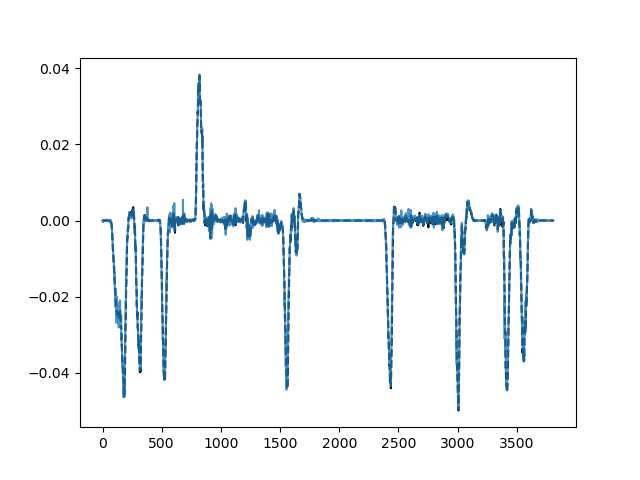

2023-05-10 00:25:56.267541: W tensorflow/core/framework/op_kernel.cc:1768] INVALID_ARGUMENT: required broadcastable shapes


InvalidArgumentError: {{function_node __wrapped__Sub_device_/job:localhost/replica:0/task:0/device:GPU:0}} required broadcastable shapes [Op:Sub]

In [60]:
pred_stds = np.loadtxt("../results/Ford_full_pred_stds_v10.txt")
pred_stds = pred_stds[(start_idx):(start_idx+runlen),:]

import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ground_truth = np.loadtxt("/media/derm/06EF-127D3/Ford/IJRR-Dataset-1/SCANS/FORD_DS1_truth.txt")/10
ground_truth = tf.cast(tf.convert_to_tensor(ground_truth), tf.float32)
# gt = (ground_truth[i+start_idx,:] + ground_truth[i+start_idx+1,:])/2 #avg between pts
# vf = (ground_truth[(start_idx+1):(start_idx+runlen+1),5] + ground_truth[start_idx:(start_idx+runlen),5])/2 #works best(?)
vf = ground_truth[(start_idx+1):(start_idx+runlen+1),5] #test

ax.plot(vf, 'k--', label = 'Ground Truth Yaw')
# ax.plot(estimates[start_idx:(start_idx+runlen),1], label = "ICET Estimated Translation (rigid)") #old rigid

# ax.plot(X_hat_history[1:,0], alpha = 0.8, label = "ICET Registration (12 State)")
# ax.plot(X_hat_history_ICET[:,0], alpha = 0.8, label = "ICET Registration (6 State)") #same params as 12 state
ax.plot(estimates[start_idx:(start_idx+runlen),5], alpha = 0.8, label = "ICET")#"ICET Registration (tuned 6 State)") #old full run optimized ICET
# ax.plot(seed_hist[:,0], 'k.', alpha = 0.3, label = "ICET initial seed" )
# ax.plot(LOAM[1:,1], alpha = 0.5, label = "LOAM")
# ax.plot(ICP[1:,1], 'g', alpha = 0.35, label = "ICP")
# ax.plot(NDT[1:,1], 'g--', alpha = 0.8, label = "NDT")

# ax.fill_between(np.linspace(0,runlen-1,runlen),
#                    vf - 2*pred_stds[:,1], vf + 2*pred_stds[:,1], 
#                    color = [0,0,0], alpha = 0.2, label = 'ICET Predicted 2σ Error Bound')

# ax.fill_between(np.linspace(0,runlen-1,runlen),
#                    vf - m_hat_history[:,0], vf + m_hat_history[:,0], 
#                    color = [1,0,0], alpha = 0.3, label = 'Distortion Bounds (12 State)')

# plot distortion bounds w.r.t. gt
ax.fill_between(np.linspace(0,runlen-2,runlen-1),
                   vf[:-1] - abs(m_hat_history[1:,5])-2*abs(pred_stds[1:,5]), 
                   vf[:-1] + abs(m_hat_history[1:,5]) + 2*abs(pred_stds[1:,5]), 
                   color = [1,0,0], alpha = 0.3, label = 'Distortion Bounds')
# ax.fill_between(np.linspace(0,runlen-3,runlen-2),
#                    vf[:-2] - abs(m_hat_history[2:,5])-2*abs(pred_stds[2:,5]), 
#                    vf[:-2] + abs(m_hat_history[2:,5]) + 2*abs(pred_stds[2:,5]), 
#                    color = [1,0,0], alpha = 0.3, label = '2σ + Distortion Bounds')

# # plot distortion bounds w.r.t. 12-State ICET Estimaes
# ax.fill_between(np.linspace(0,runlen-1,runlen),
#                    X_hat_history[:,0] - abs(m_hat_history[:,0])-2*abs(pred_stds[:,1]), 
#                    X_hat_history[:,0] + abs(m_hat_history[:,0]) + 2*abs(pred_stds[:,1]), 
#                    color = [1,0,0], alpha = 0.3, label = '2σ + 2*Distortion Bounds (12 State)')

ax.set_title("Ford Campus Dataset: 12-state ICET")
ax.set_xlabel("frame index")
ax.set_ylabel("yaw per frame (rad)")
ax.legend(loc = 'best')

In [59]:
# np.save("sample_data/Ford_m_hat_history_12_state_ICET_990",  m_hat_history) #250 frames
# np.save("sample_data/Ford_X_hat_history_12_state_ICET_990",  X_hat_history) #250 frames
# np.save("sample_data/Ford_12_state_seed_values_990", seed_hist) #250 frames

# np.save("sample_data/Ford_m_hat_history_12_state_ICET_full",  m_hat_history) 
# np.save("sample_data/Ford_X_hat_history_12_state_ICET_full",  X_hat_history) 
# np.save("sample_data/Ford_12_state_seed_values_full", seed_hist)
m_hat_history = np.load("sample_data/Ford_m_hat_history_12_state_ICET_full.npy")
X_hat_history = np.load("sample_data/Ford_X_hat_history_12_state_ICET_full.npy")
seed_hist = np.load("sample_data/Ford_12_state_seed_values_full.npy")

# np.save("sample_data/Ford_m_hat_history_12_state_ICET_full_v2",  m_hat_history) 
# np.save("sample_data/Ford_X_hat_history_12_state_ICET_full_v2",  X_hat_history) 
# np.save("sample_data/Ford_X_hat_history_6_state_ICET_full_v2",  X_hat_history_ICET) 
# np.save("sample_data/Ford_12_state_seed_values_full_v2", seed_hist)


# start_idx = 0 #990 #start on this scan
# runlen = 3680 #250

#remove outliers from m_hat_history
m_hat_history[abs(m_hat_history[:,0]) > 0.1] = 0.1 #fwd
# m_hat_history[abs(m_hat_history[:,5]) > 0.02] = 0.0 #yaw
# m_hat_history[:,5] = m_hat_history[:,5]/10 #yaw #DEBUG

### Plot Cumulative error between ICET, LOAM, and Ground Truth for forward motion (x)

In [ ]:
#plot error between ICET and absolute position
plt.rc('font',family='Times New Roman')
fig3, ax3 = plt.subplots(1,1)
font = {'fontname':'Times New Roman'}

c = 0 # x (forward movement)

# #DEBUG: why is GT continuously 0.005m short for frames 2400-3000??? #~~~~~~~~~
# vf = (ground_truth[(start_idx+1):(start_idx+runlen+1),1] + ground_truth[start_idx:(start_idx+runlen),1])/2 #works best(?)
# vf = vf.numpy()
# vf[2400:3000] += 0.005
# #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

#works best(??) -- tuned 6-state ICET
# diffx = vf - estimates[:len(vf),1] 
# diffx = (vf/0.999) - estimates[:len(vf),1]  # need to rescale timestamps
diffx = vf - estimates[:len(vf),1]*(np.append(np.diff(ts_history),1)/100_000)  # need to rescale timestamps

#  # 12-state ICET rigid transform
# # vf = (ground_truth[(start_idx+2):(start_idx+runlen+2),1] + ground_truth[(start_idx+1):(start_idx+runlen+1),1])/2 #works best(?)
# # vf = (ground_truth[(start_idx+1):(start_idx+runlen+1),1] + ground_truth[start_idx:(start_idx+runlen),1])/2 #works best(?)
# vf = ground_truth[(start_idx):(start_idx+runlen),1]
# diffx = vf - X_hat_history[:len(vf),0]


# diffx_LOAM = vf - LOAM[len(vf),1]

# diffx = ground_truth[:len(estimates),5] - estimates[:,5]

cum_err = np.zeros(np.shape(pred_stds))
cum_diffx = np.zeros(np.shape(diffx))

for i in range(np.shape(pred_stds)[0]):
    #include sensor noise calculated by ICET 
    cum_err[i,:] = np.sum(pred_stds[:i,:]**2, axis = 0)
    #add in distortion bounds
    cum_err[i,:] += np.sum(m_hat_history[:i,:]**2, axis = 0)
    #add in baseline OXTS 1-sigma errors
    cum_err[i,:] += np.sqrt(2)*np.array([0.05,0.05,0.1,0.0005,0.0005,0.001])**2
#     cum_err[i,:] += np.sqrt(2)*np.array([0.08,0.08,0.1,0.0005,0.0005,0.001745])**2
    cum_err[i,:] = np.sqrt(cum_err[i,:]) 
    
for j in range(np.shape(diffx)[0]):
    cum_diffx[j] = np.sum(diffx[:j]) 

# # error for each individual timestep --------------------------------
# ax3.plot(diffx, label = 'GPS/INS - ICET (after bias reduction)')
# # ax3.fill_between(np.linspace(0,len(pred_stds)-1,len(pred_stds)), -2*pred_stds[:,c], 2*pred_stds[:,c], 
# #                  color = (0.5,0.5,0.5,0.4), label = 'ICET Predicted 2σ Error Bounds')
# ax3.fill_between(np.linspace(0,len(pred_stds)-1,len(pred_stds)), 
#                  -m_hat_history[:,0]  - 2*pred_stds[:,c], 
#                   m_hat_history[:,0] + 2*pred_stds[:,c], 
#                  color = (0.5,0.5,0.5,0.4), label = 'Predicted Error Bounds')
# #-------------------------------------------------------------------

# #new (accumulated differences in error)--------------------------
# ax3.plot(np.linspace(0,15,np.shape(ICET_pred_stds)[0]), cum_diffx_with_ground, label = 'GPS/INS - ICET')
ax3.plot(np.linspace(0,len(pred_stds)-1,len(pred_stds)), cum_diffx, label = 'Cumulative Error in ICET Estimates')
ax3.fill_between(np.linspace(0,len(pred_stds)-1,len(pred_stds)), 
                 -cum_err[:,1], 
                 cum_err[:,1], 
                 color = (0,0,1,0.2), label = 'Predicted Error Bounds')
# # --------------------------------------------------------------------

# ax3.legend(loc = 'lower left')
ax3.legend(loc = 'upper left')
ax3.set_title("Bounding Error in Forward Motion Estimates")
ax3.set_xlabel("scan index", **font)
ax3.set_ylabel("Ground Truth x - Odometry Estimate x (m)", **font)
# ax3.set_title("Predicted vs Actual Error in yaw")
# ax3.set_xlabel("time (s)", **font)
# ax3.set_ylabel("GPS/INS Baseline yaw - Odometry Estimate yaw (rad)", **font)
# ax3.set_ylim(-0.032,0.045)
# ax3.set_ylim([-0.07,0.07])
ax3.set_xlim([0,3678])

### Repeat for yaw

In [ ]:
#plot error between ICET and absolute position
plt.rc('font',family='Times New Roman')
fig3, ax3 = plt.subplots(1,1)
font = {'fontname':'Times New Roman'}

# print(len(estimates), len(ground_truth), len(pred_stds))



# diffx = ground_truth[:len(estimates), 5] - estimates[:,5] #was this

#test
# yaw_gt = (ground_truth[(start_idx+1):(start_idx+runlen+1),5] + ground_truth[start_idx:(start_idx+runlen),5])/2 #works best(?)
yaw_gt = (ground_truth[(start_idx+2):(start_idx+runlen+2),5] + ground_truth[(start_idx+1):(start_idx+runlen+1),5])/2 #works best(?)
# diffx = yaw_gt[:len(estimates)] - estimates[:len(yaw_gt),5]
# diffx = (yaw_gt[:len(estimates)]/0.999) - estimates[:len(yaw_gt),5] #need to rescale time estimates
diffx = yaw_gt[:len(estimates)] - estimates[:len(vf),5]*(np.append(np.diff(ts_history),1)/100_000)  # need to rescale timestamps

# diffx_LOAM = vf - LOAM[len(vf),1]

cum_err = np.zeros(np.shape(estimates))
cum_diffx = np.zeros(len(estimates))

for i in range(np.shape(estimates)[0]):
    #include sensor noise calculated by ICET 
    cum_err[i,:] = 2*np.sum(pred_stds[:i,:]**2, axis = 0)
    #add in distortion bounds
    cum_err[i,:] += np.sum(m_hat_history[:i,:]**2, axis = 0)
    #add in baseline OXTS 1-sigma errors
    cum_err[i,:] += np.sqrt(2)*np.array([0.05,0.05,0.1,0.0005,0.0005,0.001])**2
#     cum_err[i,:] += np.sqrt(2)*np.array([0.08,0.08,0.1,0.0005,0.0005,0.001745])**2
    cum_err[i,:] = np.sqrt(cum_err[i,:]) 
    
for j in range(np.shape(diffx)[0]):
    cum_diffx[j] = np.sum(diffx[:j]) 

# print(np.shape(estimates))
# print(np.shape(m_hat_history[0:len(estimates),:]))
# print(len(np.linspace(0,len(estimates)-1,len(estimates))))
    
# # error for each individual timestep --------------------------------
# ax3.plot(diffx, label = 'GPS/INS - ICET')
# # ax3.fill_between(np.linspace(0,len(pred_stds)-1,len(pred_stds)), -2*pred_stds[:,c], 2*pred_stds[:,c], 
# #                  color = (0.5,0.5,0.5,0.4), label = 'ICET Predicted 2σ Error Bounds')
# ax3.fill_between(np.linspace(0,len(estimates)-1,len(m_hat_history)), 
#                  -m_hat_history[:len(estimates),0]  - 2*pred_stds[:len(estimates),5], 
#                   m_hat_history[:len(estimates),0] + 2*pred_stds[:len(estimates),5], 
#                  color = (0.5,0.5,0.5,0.4), label = 'Predicted Error Bounds')
# #-------------------------------------------------------------------

# #new (accumulated differences in error)--------------------------
# ax3.plot(np.linspace(0,15,np.shape(ICET_pred_stds)[0]), cum_diffx_with_ground, label = 'GPS/INS - ICET')
ax3.plot(np.linspace(0,len(estimates)-1,len(estimates)), cum_diffx, label = 'Cumulative Error in ICET Estimates')
ax3.fill_between(np.linspace(0,len(estimates)-1,len(estimates)), 
                 -cum_err[:,5], 
                 cum_err[:,5], 
                 color = (0,0,1,0.2), label = 'Predicted Error Bounds')
# # --------------------------------------------------------------------

ax3.legend(loc = 'upper left')
ax3.set_title("Bounding Error in Azimuth Estimates")
ax3.set_xlabel("scan index", **font)
ax3.set_ylabel("Ground Truth Azimuth - Odometry Azimuth (rad)", **font)
ax3.set_xlim([0,3678])

### Debug timestamps from Ford Dataset

In [ ]:
# [framecount, curr_timestamp_sync, curr_timestamp_dc1394,  curr_timestamp_hosttime]
ts_fn = "/media/derm/06EF-127D3/Ford/IJRR-Dataset-1/Timestamp.log"
ts = np.loadtxt(ts_fn, skiprows=1)
# print(ts)

print(np.shape(ts))

fig, ax = plt.subplots()
# ax.plot(np.diff(ts[:,1]))
ax.plot(ts[:,1])
# ax.plot(np.convolve(np.diff(ts[:,1]), np.ones(3)/3, mode='valid'))

In [ ]:
# ### DEBUG: run distortion correction just on "static" point clouds -- not helpful
# it = ICET(cloud1 = pc1, cloud2 = pc2, fid = 50, niter = 10, 
#            draw = True, group = 2, RM = True, DNN_filter = False)
# ViewInteractiveWidget(it.plt.window)
# pc1_static = it.cloud1_static
# pc2_static = it.cloud2_static

# plt = Plotter(N = 1, axes = 4, bg = (1, 1, 1), interactive = True)
# disp=[]
# disp.append(Points(pc1_static, c = "#CB2314")) 
# disp.append(Points(pc2_static, c = "#2c7c94")) 
# plt.show(disp, "raw point clouds")
# ViewInteractiveWidget(plt.window)

In [ ]:
print(np.mean(abs(pred_stds),axis = 0))
print(np.mean(m_hat_history, axis = 0))


In [ ]:
a = dat1['SCAN']
print(a.keys())
print(a['timestamp_laser'])

In [ ]:
start_idx = 0 #990 #start on this scan
runlen = 3680 #3680 #250

ts_history = np.zeros(runlen)

for i in range(runlen):
    print("---------------------------------- SCAN IDX", i + start_idx,"-------------------------------------")

    #load point clouds
    fn1 = '/media/derm/06EF-127D3/Ford/IJRR-Dataset-1/SCANS/Scan%04d.mat' %(i+start_idx+75)
    dat1 = mat4py.loadmat(fn1)
    SCAN1 = dat1['SCAN']

    ts_history[i] = SCAN1['timestamp_laser']

In [ ]:
print(np.mean(np.diff(ts_history)))
fig, ax = plt.subplots()
ax.plot(np.diff(ts_history))

In [ ]:
# np.savetxt("sample_data/ts_history.txt", ts_history)

<IPython.core.display.Javascript object>


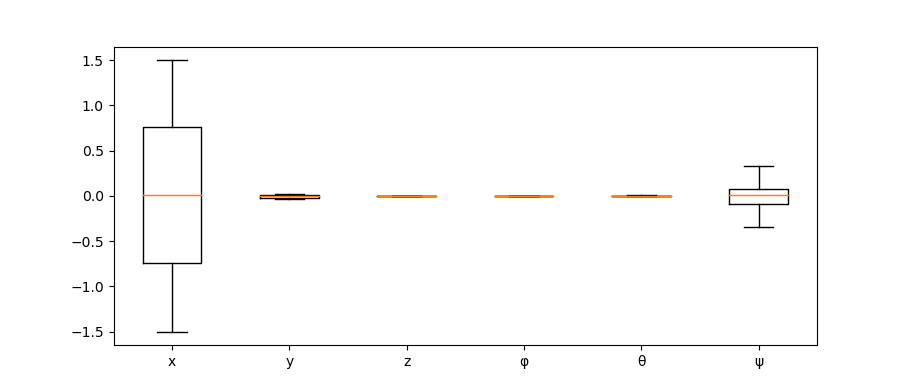

{'whiskers': [<matplotlib.lines.Line2D at 0x7fef377723a0>,
 'caps': [<matplotlib.lines.Line2D at 0x7fef37772880>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fef3a5729a0>,
 'medians': [<matplotlib.lines.Line2D at 0x7fef37772e20>,
 'fliers': [],
 'means': []}

In [51]:
#Test making box and whisker plot in matplotlib

fig, ax = plt.subplots()
# a = np.array([-1,-1,0,0,0,6])
# ax.boxplot(a)

sym = "" #hides flyers
# sym = None #show flyers 
labels = ["x", "y", "z", "φ", "θ", "ψ"]

x_err = (np.random.rand(10000) - 0.5) * 3
y_err = np.random.randn(10) * 0.03
z_err = np.random.randn(10) * 0.001
phi_err = np.random.randn(10) * 0.005
theta_err = np.random.randn(10) * 0.005
psi_err = np.random.randn(100) * 0.13


errs = np.array([x_err, y_err, z_err, phi_err, theta_err, psi_err]).T

ax.set_title("")
ax.boxplot(errs, sym = sym, labels = labels)